# Data Wrangling & Visualization Report
### Braden Poe | Nationwide Work Sample


---

## Product Overview
Build an MVP that allows allows us to **predict** the **likelihood** of a restaurant receiving a **critical inspection**.

I envision the final tool being used by the City of Las Vegas to identify restaurants that are at a high risk of critical violations, so that they can prioritize inspections. Many of the initial variables in the dataset are not helpful for model training, since they were all collected at the time of an inspection. Creating a model based solely on these variables defeats the purpose of prediction as we would be asking a restaurant inspector to enter information, such as "number of violations", that would only be revealed *after* the inspection already took place. To address this problem, I will create lags of all pertinent variables, which will allow information from the previous period to predict violation probabilities in the period of interest. This method will effectively eliminate restaurants with only one inspection from the analysis, but I feel this creates the best environment for prediction.

In [1]:
# Import raw dataset as pandas dataframe
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

data = pd.read_excel('rest_data.xlsx')

# Print total rows 
print('Total rows: {0}'.format(len(data)))

# Print list of data types
print(list(data.dtypes))


Total rows: 31419
[dtype('O'), dtype('O'), dtype('O'), dtype('O'), dtype('O'), dtype('O'), dtype('O'), dtype('O'), dtype('O'), dtype('int64'), dtype('O'), dtype('O'), dtype('<M8[ns]'), dtype('O'), dtype('O'), dtype('O'), dtype('O'), dtype('int64'), dtype('O'), dtype('O'), dtype('O'), dtype('O'), dtype('O'), dtype('O'), dtype('float64'), dtype('float64'), dtype('int64'), dtype('int64'), dtype('int64'), dtype('O'), dtype('O'), dtype('O'), dtype('O'), dtype('O'), dtype('O'), dtype('int64')]


Plenty of objects in the dataset which means a lot of cleaning, dummy generation, and manipulation will need to be done to make this a workable dataset. 

**Things to consider:**
1. Restaurant serial number or permit should be made into an id. Task: find the one that uniquely identifies restauarnts.
2. Are there cities in the dataset that should not be there? Task: Make sure all observations are in the LV metro area.
3. Task: determine amount of restaurant categories and filter.
4. Are there missing observations? Task: Determine if the dataset has missing observations.
5. Task: If missing observations exist, either drop them or try to estimate values using a low rank approximation.

In [2]:
# List how many observations are in each variable
cols = list(data.columns)
for i in range(len(data.columns)):
    print(str(cols[i]) + ' has this many unique values/strings: {0}'.format(data[cols[i]].nunique()))
    
data['FIRST_VIOLATION_TYPE'].unique()

RESTAURANT_SERIAL_NUMBER has this many unique values/strings: 31419
RESTAURANT_PERMIT_NUMBER has this many unique values/strings: 11871
RESTAURANT_NAME has this many unique values/strings: 11424
RESTAURANT_LOCATION has this many unique values/strings: 6253
RESTAURANT_CATEGORY has this many unique values/strings: 29
ADDRESS has this many unique values/strings: 5960
CITY has this many unique values/strings: 20
STATE has this many unique values/strings: 1
ZIP has this many unique values/strings: 2896
CURRENT_DEMERITS has this many unique values/strings: 49
CURRENT_GRADE has this many unique values/strings: 6
DATE_CURRENT has this many unique values/strings: 1604
INSPECTION_DATE has this many unique values/strings: 2117
INSPECTION_DATE_RAW has this many unique values/strings: 2117
INSPECTION_TIME has this many unique values/strings: 26990
EMPLOYEE_ID has this many unique values/strings: 158
INSPECTION_TYPE has this many unique values/strings: 3
INSPECTION_DEMERITS has this many unique valu

array(['Critical', 'Major', 'Non-Major', 'Imminent Health Hazard'],
      dtype=object)

In [3]:
# How many restaurant categories are there and should we subset?
print(data['RESTAURANT_CATEGORY'].value_counts())

Restaurant                     18941
Bar / Tavern                    4704
Snack Bar                       2608
Special Kitchen                 2313
Buffet                           447
Portable Unit                    389
Pantry                           339
Meat/Poultry/Seafood             302
Food Trucks / Mobile Vendor      202
Kitchen Bakery                   145
Caterer                          140
Banquet Kitchen                  123
Garde Manger                     101
Bakery Sales                      96
Vegetable Prep                    81
Institutional Food Service        76
Produce Market                    59
Confection                        56
Elementary School Kitchen         56
Concessions                       55
Banquet Support                   37
Portable Bar                      35
Grocery Store Sampling            33
Childcare Kitchens                29
Barbeque                          22
Main Kitchen                      13
Beer Bar                           8
F

There is a "primary focus on restaurants", so I will be subsetting the data to isolate locations that would be classified as a restaurant or something like a restaurant. 

In [4]:
# Subset data by restaurant type
type = list(['Restaurant','Bar / Tavern','Snack Bar','Buffet'])
data.sort_values(by=['RESTAURANT_CATEGORY'],inplace=True)
rsub = data.loc[(data['RESTAURANT_CATEGORY']== type[0]) | (data['RESTAURANT_CATEGORY']== type[1]) | (data['RESTAURANT_CATEGORY']== type[2]) | (data['RESTAURANT_CATEGORY']== type[3])]

# Now that we have a nice subset of the data, let's begin to look for duplicate entries.
dup = rsub.duplicated()
dup.replace(False,0,inplace=True)
count = dup.sum()
print('The dataset has {0} duplicate entries.'.format(count))

# Do locations seem to be duplicated? 
dup = rsub['LAT_LONG_RAW'].nunique()
print('The dataset has {0} unique locations.'.format(dup))

The dataset has 0.0 duplicate entries.
The dataset has 5344 unique locations.


While there are 26700 observations in the subset, there are only 5344 unique locations. This tells us that many restaurants or bars have multiple components within the same location that all require separate inspections, but contribute to the function of a single business. Example: The Flamingo Hotel has multiple pockets of kitchens, bars, and restaurants all located in the same latitude and longitude. Presumably, these pockets all help one overarching restaurant operate. Since I cannot definitively say this is true, I will not be modifying the dataset, but will keep it in mind when discussing results.

In [5]:
# Permit number describes an individual restaurant while serial number describes the inspection of a restaurant
import warnings 
warnings.filterwarnings('ignore')

rsub.sort_values(by=['RESTAURANT_PERMIT_NUMBER','INSPECTION_DATE'],inplace=True)

# Create reinspection dummy
rsub['re_dummy'] = rsub['INSPECTION_TYPE']
rsub['re_dummy'] = rsub['re_dummy'].replace(['Routine Inspection','Re-inspection'],[0,1])

# Let's groupby permit number and create a lag variable for re-inspection. 
# This lag tells us if a re-inspection occured prior to the current inspection
rsub['re_lag'] = rsub.groupby('RESTAURANT_PERMIT_NUMBER')['re_dummy'].shift(1)

## Drop Re-inspection 
rsub = rsub[rsub['INSPECTION_TYPE'] != 'Re-inspection']

# Create lag for number of violations
rsub['numvio_lag'] = rsub.groupby('RESTAURANT_PERMIT_NUMBER')['NUMBER_OF_VIOLATIONS'].shift(1)

# Number of critical violations 
def rule1(x,y,z):
    if x == 'Critical' and y == 'Critical' and z == 'Critical':
        n = 3
    elif (x == 'Critical' and y == 'Critical') or (x == 'Critical' and z == 'Critical') or (z == 'Critical' and y == 'Critical'):
        n = 2
    elif x == 'Critical' or y == 'Critical' or z == 'Critical':
        n = 1
    else: 
        n = 0
    return n

# Number of Major violations
def rule2(x,y,z):
    if x == 'Major' and y == 'Major' and z == 'Major':
        n = 3
    elif (x == 'Major' and y == 'Major') or (x == 'Major' and z == 'Major') or (z == 'Major' and y == 'Major'):
        n = 2
    elif x == 'Major' or y == 'Major' or z == 'Major':
        n = 1
    else: 
        n = 0
    return n

# Number of Non-major violations
def rule3(x,y,z):
    if x == 'Non-Major' and y == 'Non-Major' and z == 'Non-Major':
        n = 3
    elif (x == 'Non-Major' and y == 'Non-Major') or (x == 'Non-Major' and z == 'Non-Major') or (z == 'Non-Major' and y == 'Non-Major'):
        n = 2
    elif x == 'Non-Major' or y == 'Non-Major' or z == 'Non-Major':
        n = 1
    else: 
        n = 0
    return n

# Number of imminent health hazards
def rule4(x,y,z):
    t = 'Imminent Health Hazard'
    if x == t and y == t and z == t:
        n = 3
    elif (x == t and y == t) or (x == t and z == t) or (z == t and y == t):
        n = 2
    elif x == t or y == t or z == t:
        n = 1
    else: 
        n = 0
    return n
    
rsub['crit_ct'] = rsub.apply(lambda x: rule1(x['FIRST_VIOLATION_TYPE'],x['SECOND_VIOLATION_TYPE'],x['THIRD_VIOLATION_TYPE']),axis=1).astype(int)
rsub['major_ct'] = rsub.apply(lambda x: rule2(x['FIRST_VIOLATION_TYPE'],x['SECOND_VIOLATION_TYPE'],x['THIRD_VIOLATION_TYPE']),axis=1)
rsub['nm_ct'] = rsub.apply(lambda x: rule3(x['FIRST_VIOLATION_TYPE'],x['SECOND_VIOLATION_TYPE'],x['THIRD_VIOLATION_TYPE']),axis=1)
rsub['other_ct'] = rsub.apply(lambda x: rule4(x['FIRST_VIOLATION_TYPE'],x['SECOND_VIOLATION_TYPE'],x['THIRD_VIOLATION_TYPE']),axis=1)


# Create lags of violation type 
rsub['crit_lag'] = rsub.groupby('RESTAURANT_PERMIT_NUMBER')['crit_ct'].shift(1)
rsub['major_lag'] = rsub.groupby('RESTAURANT_PERMIT_NUMBER')['major_ct'].shift(1)
rsub['nm_lag'] = rsub.groupby('RESTAURANT_PERMIT_NUMBER')['nm_ct'].shift(1)
rsub['other_lag'] = rsub.groupby('RESTAURANT_PERMIT_NUMBER')['other_ct'].shift(1)

# Create lags of inspection demerits 
rsub['demerits_lag'] = rsub.groupby('RESTAURANT_PERMIT_NUMBER')['INSPECTION_DEMERITS'].shift(1)

# Create grade lag 
rsub['grade_lag'] = rsub.groupby('RESTAURANT_PERMIT_NUMBER')['INSPECTION_GRADE'].shift(1)

# Create first violation type = critical as a response 
rsub['response'] = (rsub['FIRST_VIOLATION_TYPE'] == 'Critical').astype(int)

# Clean up city name errors
rsub['CITY'].loc[rsub['CITY']=='HendeSON'] = 'Henderson'
rsub['CITY'].loc[rsub['CITY']=='HENDERSON'] = 'Henderson'

One of the issues with this analysis is that we're looking to build a product that can help predict restaurant inspections, but we don't have much of a time dimension in the current dataset. This means that most of the inputs into the model will not be known before an inspection. The creation of lags is an attempt to address this problem.

In [6]:
# Clean up rsub into the final set we will use
final = rsub

## Recategorize by restaurant type 
final['RESTAURANT_CATEGORY'].loc[final['RESTAURANT_CATEGORY']=='Restaurant'] = 0
final['RESTAURANT_CATEGORY'].loc[final['RESTAURANT_CATEGORY']=='Bar / Tavern'] = 1
final['RESTAURANT_CATEGORY'].loc[final['RESTAURANT_CATEGORY']=='Buffet'] = 2
final['RESTAURANT_CATEGORY'].loc[final['RESTAURANT_CATEGORY']=='Snack Bar'] = 3

# Trim zip since there are too many unique zip codes to be included in the analysis
## Drop missing zips 
final['ZIP'] = final['ZIP'].dropna()
final['ziptrim'] = final['ZIP'].str.slice(start = 0, stop = 5, step =1)

# Add in grade indicator
final['INSPECTION_GRADE'] = final['INSPECTION_GRADE'].dropna()
final['INSPECTION_GRADE'] = final['INSPECTION_GRADE'].astype(str)
final['INSPECTION_GRADE'] = final['INSPECTION_GRADE'].loc[final['INSPECTION_GRADE']!='nan']
final['INSPECTION_GRADE'].loc[final['INSPECTION_GRADE']=='a'] = 'A'
final['A'] = (final['INSPECTION_GRADE']=='A').astype(int)
final['B'] = (final['INSPECTION_GRADE']=='B').astype(int)
final['C'] = (final['INSPECTION_GRADE']=='C').astype(int)
final['O'] = (final['INSPECTION_GRADE']=='O').astype(int)
final['X'] = (final['INSPECTION_GRADE']=='X').astype(int)

# Add in lags of grades 
# Create lags of violation type 
final['a_lag'] = final['A'].shift(1)
final['b_lag'] = final['B'].shift(1)
final['c_lag'] = final['C'].shift(1)
final['o_lag'] = final['O'].shift(1)
final['x_lag'] = final['X'].shift(1)

# Top violations may be significant in prediciting critical vs non-critical, so let's make dummies of the top 10.
final['FIRST_VIOLATION'] = final['FIRST_VIOLATION'].astype(str)
dums = pd.get_dummies(final['FIRST_VIOLATION'])
keep = ['202','209','211','214','206','14','13','212','213','208']
dums= dums[keep]
final = pd.concat([final,dums],axis=1)
# Lag first violations
final[keep] = final[keep].shift(1)

#Drop unwanted columns
strip = ['RESTAURANT_SERIAL_NUMBER','RESTAURANT_NAME','RESTAURANT_LOCATION','STATE','CURRENT_GRADE',
        'DATE_CURRENT','INSPECTION_DATE_RAW','INSPECTION_DATE','CURRENT_DEMERITS','DATE_CURRENT',
        'INSPECTION_TYPE','PERMIT_STATUS','INSPECTION_RESULT','RECORD_UPDATED','LAT_LONG_RAW','FIRST_VIOLATION_DS',
        'SECOND_VIOLATION_DS','THIRD_VIOLATION_DS','INSPECTION_TIME','EMPLOYEE_ID','VIOLATIONS_RAW']
final.drop(strip,axis=1,inplace=True)

# Rename columns for ease
final.rename(columns={'RESTAURANT_PERMIT_NUMBER':'permit','RESTAURANT_CATEGORY':'category','INSPECTION_DEMERITS':'demerits',
                     'INSPECTION_GRADE':'grade','LOCATION_LATITUDE':'lat','LOCATION_LONGITUDE':'long',
                     'FIRST_VIOLATION':'first','SECOND_VIOLATION':'second','THIRD_VIOLATION':'third',
                     'FIRST_VIOLATION_TYPE':'firsttype','SECOND_VIOLATION_TYPE':'secondtype',
                     'THIRD_VIOLATION_TYPE':'thirdtype','NUMBER_OF_VIOLATIONS':'numvio'},inplace=True)
final.columns = final.columns.str.lower()

# Create a count column that will come in handy during aggregation for visualizations
final['count'] = 1

# Get trimmed zip code dummies
dums = pd.get_dummies(final['ziptrim'])
final = pd.concat([final,dums],axis=1)

# Create city dummies
final['city'] = final['city'].astype(str)
final['city'] = final['city'].str.lower()
dums = pd.get_dummies(final['city'])
final = pd.concat([final,dums],axis=1)
final = final.drop('nan',axis=1)

# View final set of variables
x = np.asarray(final.columns)
with np.printoptions(threshold=np.inf):
    print(x)

['permit' 'category' 'address' 'city' 'zip' 'demerits' 'grade' 'lat'
 'long' 'first' 'second' 'third' 'firsttype' 'secondtype' 'thirdtype'
 'numvio' 're_dummy' 're_lag' 'numvio_lag' 'crit_ct' 'major_ct' 'nm_ct'
 'other_ct' 'crit_lag' 'major_lag' 'nm_lag' 'other_lag' 'demerits_lag'
 'grade_lag' 'response' 'ziptrim' 'a' 'b' 'c' 'o' 'x' 'a_lag' 'b_lag'
 'c_lag' 'o_lag' 'x_lag' '202' '209' '211' '214' '206' '14' '13' '212'
 '213' '208' 'count' '55121' '80109' '88108' '89002' '89004' '89005'
 '89006' '89009' '89011' '89012' '89014' '89015' '89017' '89018' '89019'
 '89021' '89025' '89027' '89029' '89030' '89031' '89032' '89034' '89036'
 '89039' '89040' '89041' '89044' '89046' '89052' '89074' '89081' '89084'
 '89085' '89086' '89101' '89102' '89103' '89104' '89105' '89106' '89107'
 '89108' '89109' '89110' '89111' '89113' '89114' '89115' '89117' '89118'
 '89119' '89120' '89121' '89122' '89123' '89124' '89127' '89128' '89129'
 '89130' '89131' '89134' '89135' '89138' '89139' '89140' '89141' '8914

Variables look all set. I will worry about standardizing in the prediction section of the report. I also want to keep in mind the somewhat high dimensionality of the dataset - will look to use an aggressive regularizer in feature selection since all of these dummies are not significant.

---

# Visualizations

## Heatmaps Code

Visualizing the data allows us to view variability within the dataset in several different ways. I will generate heatmaps using Geopandas to represent the density of violations by zipcode weighted by the number of inspections per zip code. These heatmaps will provide insight into critical violation hotspots in the state and will help us determine if it would be helpful to use location in our predictive model.

In [7]:
# Import shapefile of LV zip codes 
import geopandas as gpd

LV = 'Zip_Codes.shp'
map = gpd.read_file(LV)

# Aggregate the data on the zipcode level so that we can merge it with the shapefile
agg = final.groupby('ziptrim').agg({'crit_ct':'sum','major_ct':'sum','nm_ct':'sum','count':'sum','demerits':'sum'})
agg['crit_ct'] = agg['crit_ct'].astype(int)
agg['major_ct'] = agg['major_ct'].astype(int)
agg['nm_ct'] = agg['nm_ct'].astype(int)
agg['demerits'] = agg['demerits'].astype(int)
agg = agg.reset_index()
agg['ziptrim'] = agg['ziptrim'].astype(int)

# Per inspection weighting because we don't want # of inspections to skew violation count
agg['crit_per'] = agg['crit_ct']/agg['count']
agg['major_per'] = agg['major_ct']/agg['count']
agg['nm_per'] = agg['nm_ct']/agg['count']

# Per inspection demerits
agg['dem_per'] = agg['demerits']/agg['count']

# Merging aggregated data with the shapefile
merged = map.set_index('ZIP').join(agg.set_index('ziptrim'))
merged['crit_per'] = merged['crit_per'].fillna(0)
merged['major_per'] = merged['major_per'].fillna(0)
merged['nm_per'] = merged['nm_per'].fillna(0)
merged['dem_per'] = merged['dem_per'].fillna(0)

# Generating plot
# set the range for the choropleth
vmin, vmax = 0.0, 2.5
# create figure and axes for Matplotlib
fig, ax = plt.subplots(1,3, figsize=(30, 10))
merged.plot(column='crit_per', cmap='Blues', linewidth=0.8, ax=ax[0], edgecolor='0.8')
merged.plot(column='major_per', cmap='Oranges', linewidth=0.8, ax=ax[1], edgecolor='0.8')
merged.plot(column='nm_per', cmap='Greens', linewidth=0.8, ax=ax[2], edgecolor='0.8')
ax[0].axis('off')

ax[0].set_title('Critical Violations per Inspection by Zip', fontdict={'fontsize': '25', 'fontweight' : '3'})


ax[1].axis('off')

ax[1].set_title('Major Violations per Inspection by Zip', fontdict={'fontsize': '25', 'fontweight' : '3'})

ax[1].annotate('Source: City of Las Vegas Open Data, 2019',xy=(0.1, .08),
            xycoords='figure fraction', horizontalalignment='left',
            verticalalignment='top', fontsize=12, color='#555555')

ax[2].axis('off')

ax[2].set_title('Non-Major Violations per Inspection by Zip', fontdict={'fontsize': '25', 'fontweight' : '3'})



fig.savefig('critical.png', dpi=300)
plt.close(fig='all')

### Additional heatmap:  
The heatmaps created above do not look at demerits per inspection, but I will also investigate this variable to see if it differs from critical violations per inspection.

In [8]:
# Plot
# set the range for the choropleth
vmin, vmax = 0.0, merged['dem_per'].max()

# create figure and axes for Matplotlib
fig, ax = plt.subplots(1,2, figsize=(15, 5))
merged.plot(column='dem_per', cmap='Blues', linewidth=0.8, ax=ax[0], edgecolor='0.8')
merged.plot(column='crit_per',cmap='Blues',linewidth=0.8, ax=ax[1], edgecolor='0.8')
ax[0].axis('off')
ax[1].axis('off')

ax[0].set_title('Demerits per Inspection by Zip', fontdict={'fontsize': '15', 'fontweight' : '3'})
ax[1].set_title('Critical Violations per Inspection by Zip',fontdict={'fontsize': '15', 'fontweight' : '3'})

fig.savefig('dem_vs_critical.png', dpi=300)
plt.close(fig='all')

# Generate variables to call heatmaps in discussion below.
from PIL import Image as i
crit = i.open('critical.png')
dem = i.open('dem_vs_critical.png')

---

## Heatmap Analysis

### Heatmap 1:
Listed below is the first set of heatmaps, which compares violation types between zip codes. Because the Las Vegas Metro area is so large, the heatmaps are spanning a broad area.

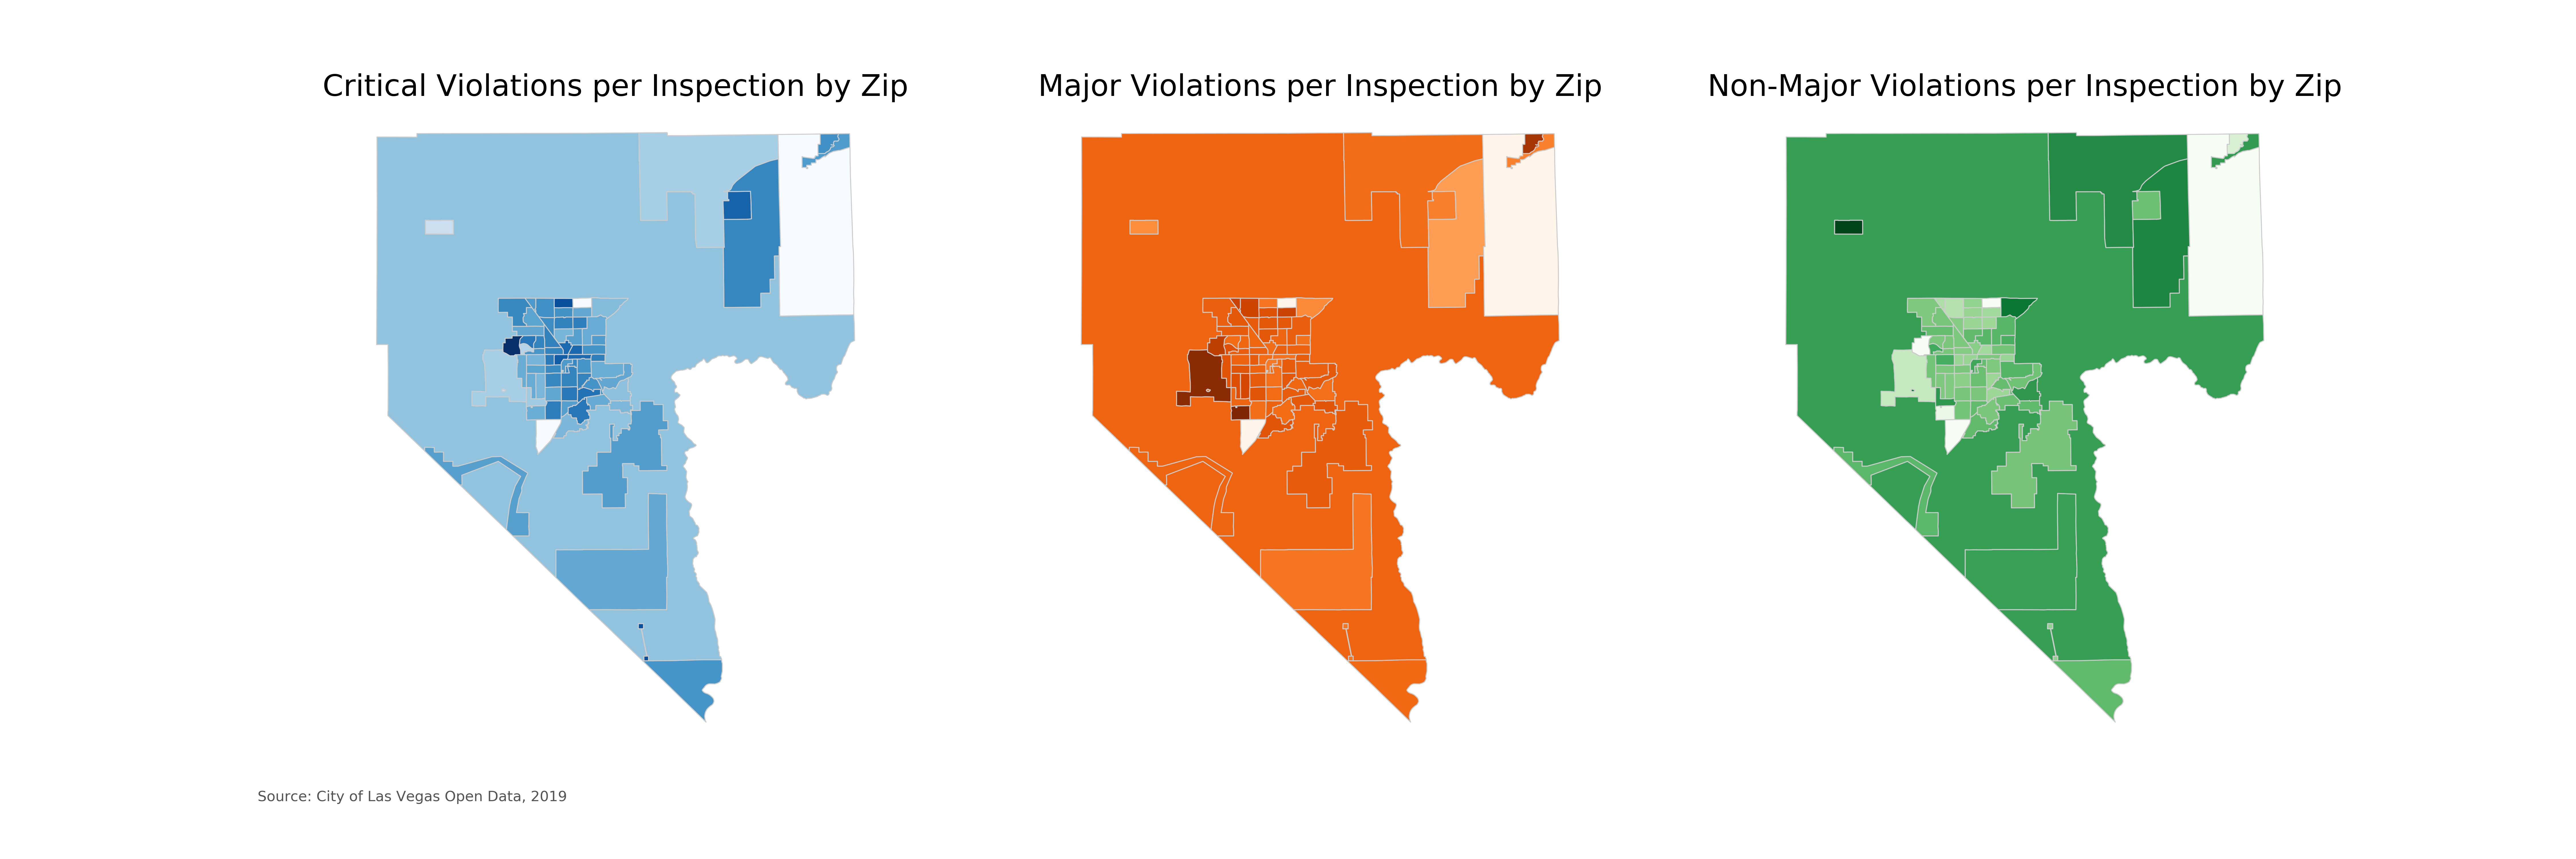

In [9]:
crit

### Takeaways:

The heatmaps are helpful in gaining a better understanding of where violations are occuring and at what frequency. The maps look at violations per inspection and I only consider the first three listed violations. Here are a few immediate takeaways that I will keep in mind during the prediction portion of the report.
1. The types of violations we see are not constantly distributed across the state. 
2. More densely populated zip codes have a higher concentration of critical violations than less densely populated regions. 
3. Judging by the density of critical violations, I imagine that location is going to play an extremely strong role in predicting critical violations. I want to ensure there is enough variability in the dataset, because our MVP won't be helpful if it is simply predicting violation probability in period "t" based on location and violation status in period "t-1".

### Heatmap 2:

The second heatmap listed below compares demerits per inspection with critical violations per inspection. The difference in magnitudes does not matter between these two graphs as I am more concerned with correlations between zip codes. The closer the colors means the higher the correlation.

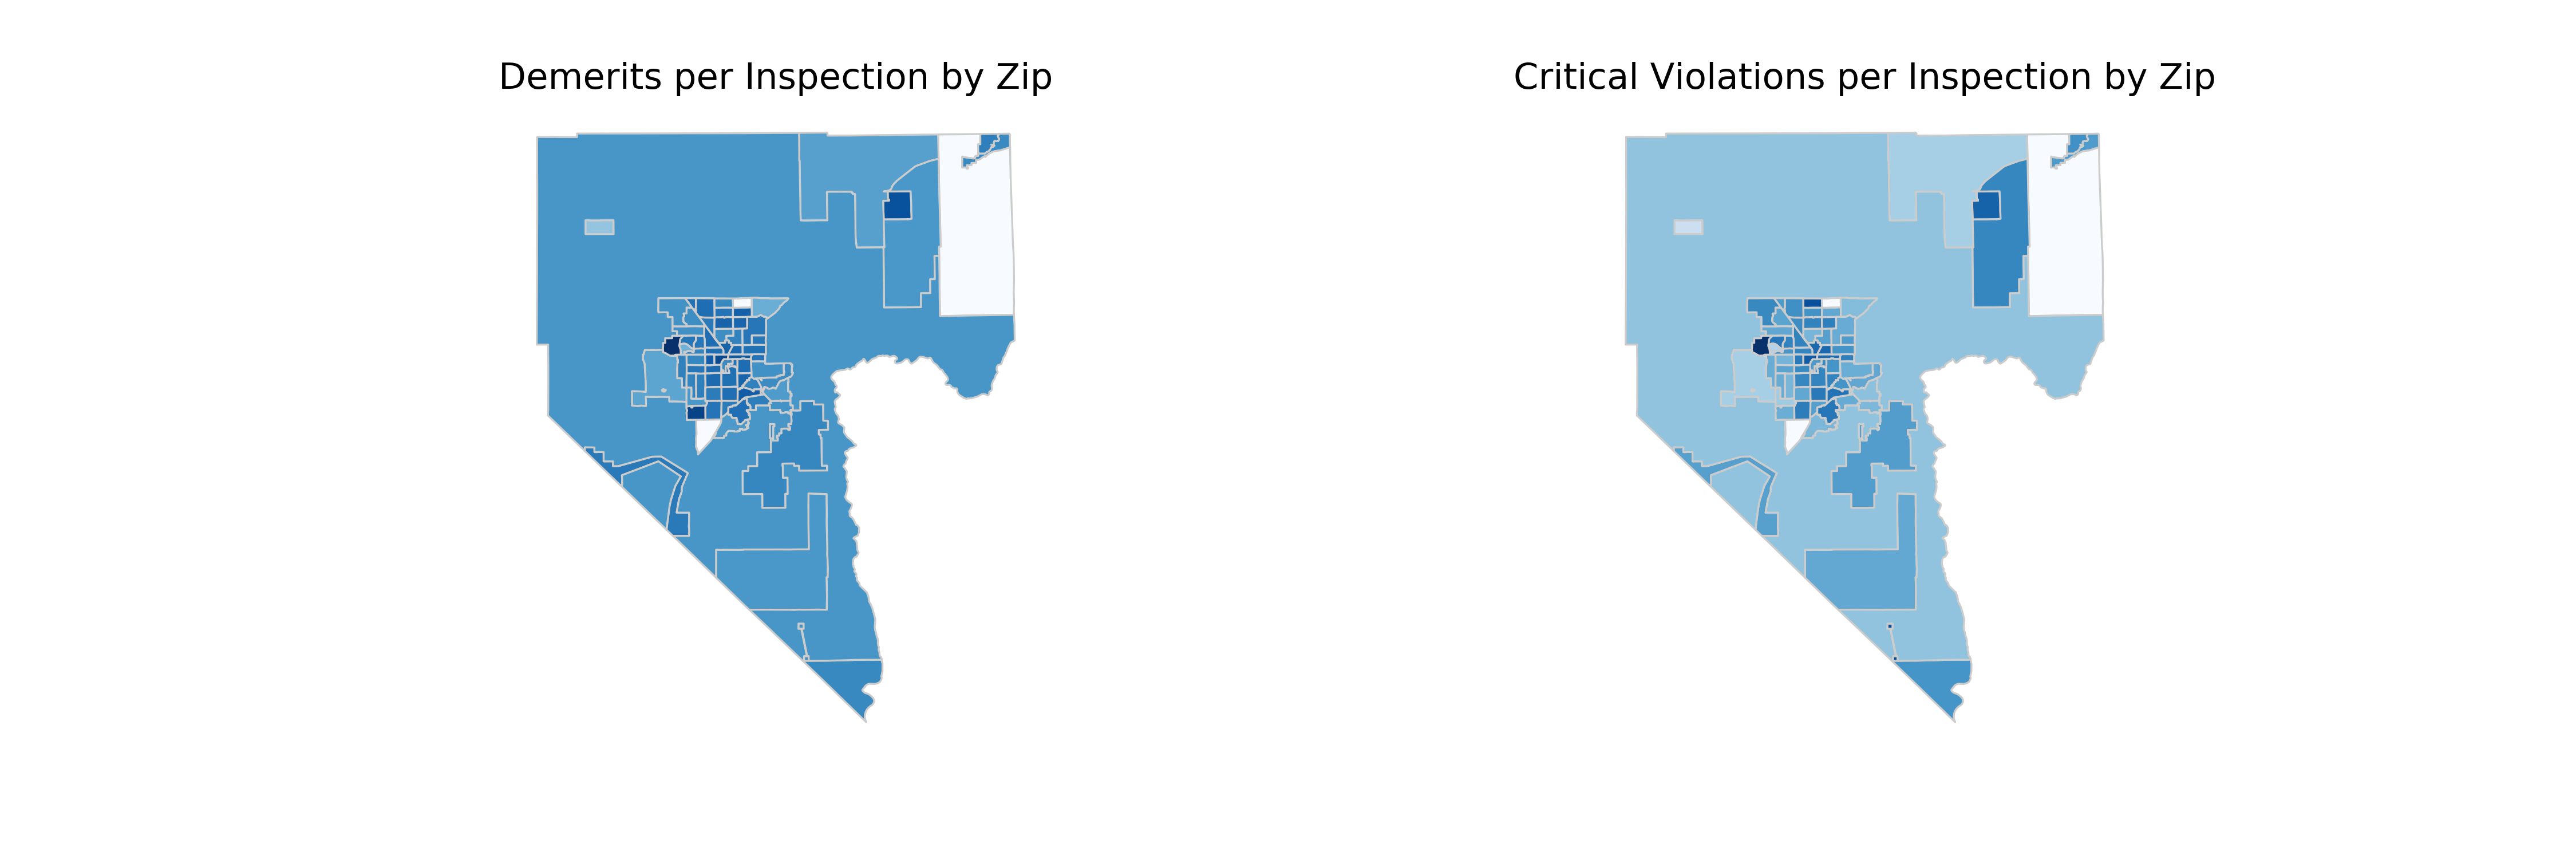

In [10]:
dem

### Takeaways:

There does appear to be some variability between demerits per inspection and critical violations per inspection at the zip code level, which indicates that collinearity should not be a significant problem the models we run as long as location is controlled for in some manner. That being said, I will still press forward with a correlation matrix and statistical tests to rule out concern for multicollinearity.

---

## Correlation Matrix Code

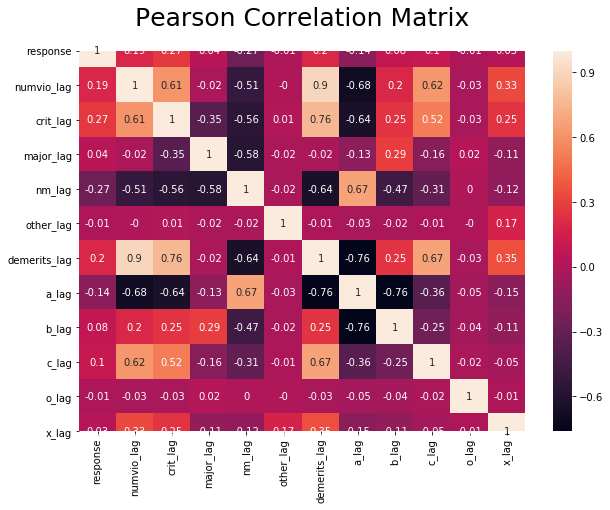

In [11]:
# Use seaborn to create matrix 
import seaborn as sns

# Restrict final to variables of interest.
cols_to_get = ['response','numvio_lag','re_lag','crit_lag','major_lag','nm_lag','other_lag','demerits_lag',
               'a_lag','b_lag','c_lag','o_lag','x_lag']

df = final[cols_to_get]
corrMatrix = df.corr(method="pearson").round(2)
x = corrMatrix['response'].abs().sort_values(ascending=False)
f, ax = plt.subplots(figsize=(10, 7))
sns.heatmap(corrMatrix, annot=True,ax=ax)
plt.title('Pearson Correlation Matrix', fontsize=25,pad=25)
plt.show()

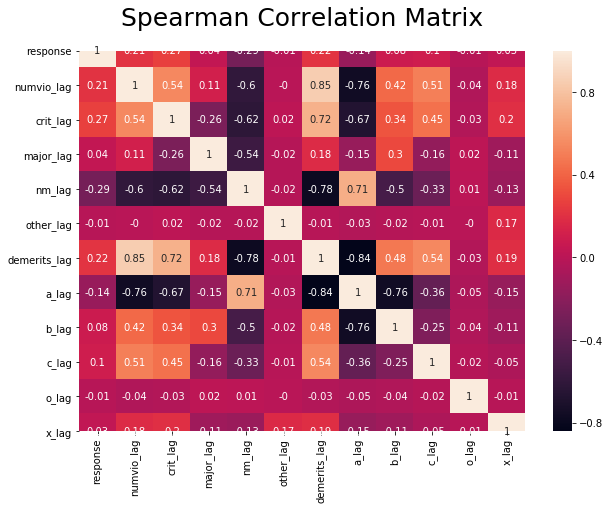

In [12]:
# Let's assume a non-linear relationship between variables
corrMatrix = df.corr(method="spearman").round(2)
x = corrMatrix['response'].abs().sort_values(ascending=False)
f, ax = plt.subplots(figsize=(10, 7))
sns.heatmap(corrMatrix, annot=True,ax=ax)
plt.title('Spearman Correlation Matrix', fontsize=25,pad=25)
plt.show()

## Correlation Matrix Analysis

While I don't want to perform feature selection yet, this correlation matrix paints a clearer picture of important variables. In addition to the importance of location, I have ranked the following variables below from most correlated with response to least correlated:

In [13]:
#Spearman
corrMatrix['response'].sort_values(ascending=False)

response        1.00
crit_lag        0.27
demerits_lag    0.22
numvio_lag      0.21
c_lag           0.10
b_lag           0.08
major_lag       0.04
x_lag           0.03
o_lag          -0.01
other_lag      -0.01
a_lag          -0.14
nm_lag         -0.29
Name: response, dtype: float64

The immediate takeaways are that poor performance in the previous period is highly correlated with poor performance in the current period. Higher numbers of demerits, total violations, and critical violations all lead to a greater chance of a critical violation in the current period. Non-major violations in the previous period has a correlation that is exactly the opposite of critical violations and an A-grade in the previous period is also negatively correlated with response.

I'm fairly happy with the overall output of both correlation matrices. Whether we make distributional assumptions using Pearson's correlation coefficient or allow non-linearity with Spearman's coefficient, it is clear that most variables are *not* highly correlated with one another. This conclusion will be helpful to remember when interpreting random forest output.

---

## Distribution Plots Code: Critical vs. Non-Critical 

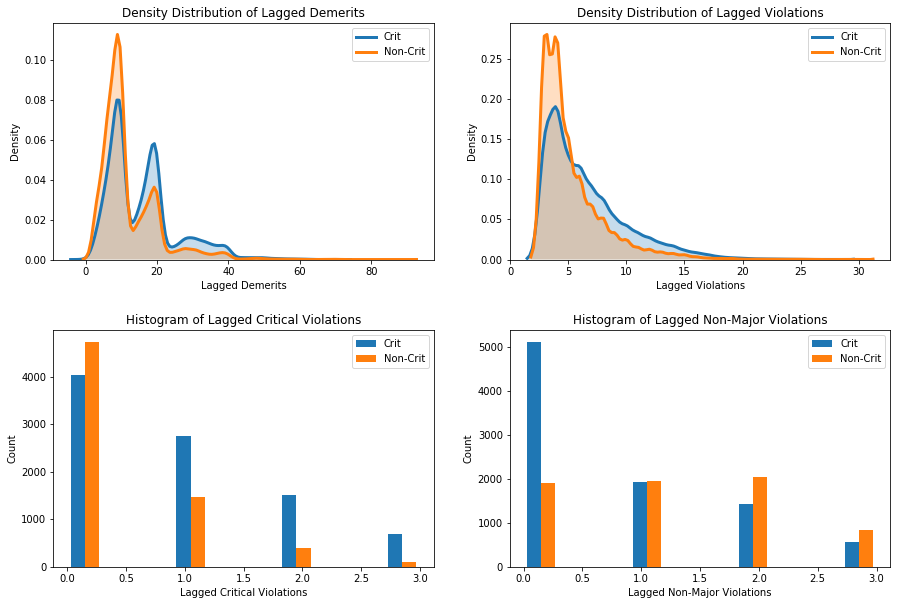

In [14]:
# Make a critical subset 
crit = final.loc[final['response']==1]

# Make a non-crit subset
noncrit = final.loc[final['response']==0]

# Create distributonal subplots for non-location based data
fig, ax = plt.subplots(2,2,figsize=(15,10))  
plt.subplots_adjust(hspace=.3)
# Demerits_Lag distribution plot
sns.distplot(crit['demerits_lag'], hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3}, label = 'Crit',ax=ax[0,0])
sns.distplot(noncrit['demerits_lag'], hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3}, label = 'Non-Crit',ax=ax[0,0])
ax[0,0].set_xlabel('Lagged Demerits')
ax[0,0].set_ylabel('Density')
ax[0,0].set_title('Density Distribution of Lagged Demerits')

#Number of Violations lagged distribution plot
sns.distplot(crit['numvio_lag'], hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3}, label = 'Crit',ax=ax[0,1])
sns.distplot(noncrit['numvio_lag'], hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3}, label = 'Non-Crit',ax=ax[0,1])
ax[0,1].set_xlabel('Lagged Violations')
ax[0,1].set_ylabel('Density')
ax[0,1].set_title('Density Distribution of Lagged Violations')

# Lagged Critical Violation Count
ax[1,0].hist([crit['crit_lag'],noncrit['crit_lag']],label=['Crit','Non-Crit'])
ax[1,0].legend()
ax[1,0].set_title('Histogram of Lagged Critical Violations')
ax[1,0].set_xlabel('Lagged Critical Violations')
ax[1,0].set_ylabel('Count')

# Lagged Non-major violation count
ax[1,1].hist([crit['nm_lag'],noncrit['nm_lag']],label=['Crit','Non-Crit'])
ax[1,1].legend()
ax[1,1].set_title('Histogram of Lagged Non-Major Violations')
ax[1,1].set_xlabel('Lagged Non-Major Violations')
ax[1,1].set_ylabel('Count')

plt.show()

## Distribution Plots Analysis: Critical vs. Non-Critical

The plots are a nice visual confirmation that the variables have different distributions for both sides of the binary response, but the data is also highly inseparable. This is an indication that any type of SVM may have difficulty creating an adequate margin for the following prediction task.

---

# Summary

There are several key takeaways that I want to highlight before moving into the predictive portion of the report. 
1. First, predicted critical violation status appears to rely heavily on a restaurants past performance, which indicates that restaurants exhibit somewhat static behavior over time.
2. Location will play a key factor in predicted violation based on the heat maps generated in this report. I expect that many of the city and zip code indicator variables will remain after regularization in the predictive stage.
3. Many observations needed to be dropped in order to make analysis statistically viable. As a result, the predictive model will likely perform worse on new restaurants, because restaurants with only one inspection are removed from the training data.
4. The inseparability of the dependent variable means that a support vector machine is not the optimal approach to completing this prediction task.
5. Creating more accurate predictions relies heavily on merging additional data into the model, which will be discussed at the end of the following report.


---

### Final Trimming of dataset

In [15]:
# Remove any variables that I am 100% certain won't be used in the analysis:
with np.printoptions(threshold=np.inf):
    print(np.array(crit.columns))

['permit' 'category' 'address' 'city' 'zip' 'demerits' 'grade' 'lat'
 'long' 'first' 'second' 'third' 'firsttype' 'secondtype' 'thirdtype'
 'numvio' 're_dummy' 're_lag' 'numvio_lag' 'crit_ct' 'major_ct' 'nm_ct'
 'other_ct' 'crit_lag' 'major_lag' 'nm_lag' 'other_lag' 'demerits_lag'
 'grade_lag' 'response' 'ziptrim' 'a' 'b' 'c' 'o' 'x' 'a_lag' 'b_lag'
 'c_lag' 'o_lag' 'x_lag' '202' '209' '211' '214' '206' '14' '13' '212'
 '213' '208' 'count' '55121' '80109' '88108' '89002' '89004' '89005'
 '89006' '89009' '89011' '89012' '89014' '89015' '89017' '89018' '89019'
 '89021' '89025' '89027' '89029' '89030' '89031' '89032' '89034' '89036'
 '89039' '89040' '89041' '89044' '89046' '89052' '89074' '89081' '89084'
 '89085' '89086' '89101' '89102' '89103' '89104' '89105' '89106' '89107'
 '89108' '89109' '89110' '89111' '89113' '89114' '89115' '89117' '89118'
 '89119' '89120' '89121' '89122' '89123' '89124' '89127' '89128' '89129'
 '89130' '89131' '89134' '89135' '89138' '89139' '89140' '89141' '8914

In [16]:
# Remove columns 

cols_to_drop = ['permit','category','address','city','zip','demerits','grade','lat','long',
               'first','second','third','firsttype','secondtype','thirdtype','numvio','re_dummy',
               're_lag','ziptrim','count','grade_lag','crit_ct','major_ct','nm_ct','other_ct','a','b','c','o','x']

final = final.drop(cols_to_drop,axis=1)

# Drop missing values that are a result of the lags 
final = final.dropna(axis=0)

final.isnull().sum().sum()

0

With no missing values remaining we are perfectly set up to run some predictive models.

In [17]:
final.to_csv('predict.csv')